In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import losses, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## **GPU Utilization**

Deep neural networks process vast amounts of data and perform billions of computations, making training time a critical factor. GPUs (Graphics Processing Units) are designed to handle massive parallel computations, significantly accelerating model training compared to CPUs.

GPU Utilization is important because of:

*   faster training
*   efficient resource usage
*   scalability
*   cost-effectiveness

In [3]:
# checking to see if GPU is detected
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# setting tensorflow to use GPU (if available)
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Using GPU: {device_name}")
else:
    print("No GPU found. Training will proceed on CPU.")

Num GPUs Available: 0
No GPU found. Training will proceed on CPU.


In [4]:
from tensorflow.keras import mixed_precision

# mixed precision for better performance
mixed_precision.set_global_policy("mixed_float16")

# allocating GPU memory dynamically
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

## **CIFAR-10 Dataset**

The CIFAR-10 (Canadian Institute For Advanced Research) dataset is one of the most widely used benchmarks in image classification. It consists of:

**60,000 Color Images** – Each image is 32x32 pixels with RGB channels.

**10 Balanced Classes** – 6,000 images per class, covering a diverse range of objects:

*   ✈️ Airplane
*   🚗 Automobile
*   🐦 Bird
*   🐈 Cat
*   🦌 Deer
*   🐕 Dog
*   🐸 Frog
*   🐎 Horse
*   🚢 Ship
*   🚚 Truck

CIFAR-10 is a small yet challenging dataset for testing new architectures. There is no class imbalance, so we can be sure that the models are being trained fairly. This data is suitable for experiments even on limited hardware and is widely used as one of the famous benchmarks for evaluating DL model performance.

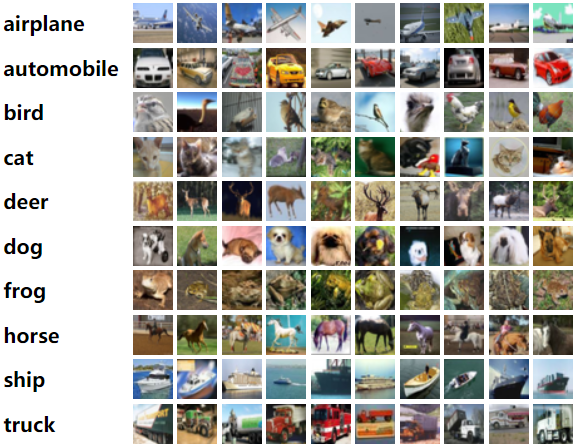

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalizing the data to [0, 1] range
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot encoding the labels for classification tasks
y_train_class = tf.keras.utils.to_categorical(y_train, 10)
y_test_class = tf.keras.utils.to_categorical(y_test, 10)

# for regression, we are using the class labels as continuous values
y_train_reg = y_train.astype(float)
y_test_reg = y_test.astype(float)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## **AlexNet**

AlexNet is a CNN architecture, designed by Alex Krizhevsky in collaboration with Ilya Sutskever and Geoffrey Hinton, who was Krizhevsky's Ph.D. advisor at the University of Toronto in 2012. It has 60 million parameters and 650,000 neurons.

The original paper's primary result was that the depth of the model is essential for its high performance, which is computationally expensive, but is made feasible due to the utilization of GPUs during training. AlexNet influenced a large number of subsequent work in deep learning, especially in applying neural networks to computer vision.

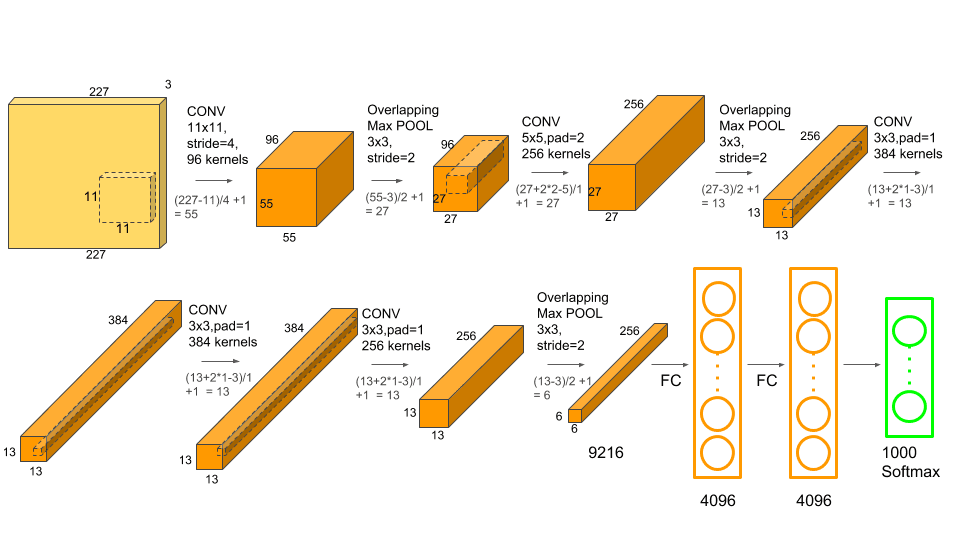

AlexNet contains eight layers: the first five are convolutional layers, some of them followed by max-pooling layers, and the last three are fully connected layers. The network, except the last layer, is split into two copies, each run on one GPU.

The entire structure can be written as

(CNN → RN → MP)² → (CNN³ → MP) → (FC → DO)² → Linear → softmax

where

*   CNN = convolutional layer (with ReLU activation)
*   RN = local response normalization
*   MP = maxpooling
*   FC = fully connected layer (with ReLU activation)
*   Linear = fully connected layer (without activation)
*   DO = dropout

AlexNet uses the non-saturating ReLU activation function, which trains better than tanh and sigmoid.

### **Classification**

In [5]:
def create_alexnet_class(input_shape, num_classes=10):
    model = Sequential()

    model.add(Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    # flattening the output from convolution layers
    model.add(Flatten())

    # fully connected layer 1
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # fully connected layer 2
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # classification layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [6]:
# defining the input shape for CIFAR-10 (32x32 RGB images)
input_shape = (32, 32, 3)

In [7]:
with tf.device('/GPU:0'):
    model_class = create_alexnet_class(input_shape, num_classes=10)
    model_class.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history_class = model_class.fit(x_train, y_train_class, epochs=10, batch_size=64, validation_data=(x_test, y_test_class))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.1826 - loss: 2.0916 - val_accuracy: 0.2892 - val_loss: 1.8465
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3271 - loss: 1.7559 - val_accuracy: 0.3579 - val_loss: 1.6786
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3879 - loss: 1.6494 - val_accuracy: 0.4203 - val_loss: 1.5766
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4354 - loss: 1.5554 - val_accuracy: 0.4699 - val_loss: 1.4819
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4598 - loss: 1.4948 - val_accuracy: 0.4796 - val_loss: 1.4585
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4842 - loss: 1.4325 - val_accuracy: 0.4630 - val_loss: 1.5340
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4922 - loss: 1.4120 - val_accuracy: 0.4801 - val_loss: 1.4413
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5121 - loss: 1.3828 - val_acc

In [8]:
test_loss_class, test_acc_class = model_class.evaluate(x_test, y_test_class)
print(f"Test Accuracy for Classification Task: {test_acc_class * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5017 - loss: 1.4112
Test Accuracy for Classification Task: 50.07%


In [9]:
def plot_sample_classification_predictions(model, x_test, y_test):
    """Displays some test images with actual and predicted labels for classification."""
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']  # CIFAR-10 Labels

    fig, axes = plt.subplots(3, 5, figsize=(12, 8))
    indices = np.random.choice(len(x_test), 15, replace=False)

    for i, ax in enumerate(axes.flat):
        img = x_test[indices[i]]
        true_label = np.argmax(y_test[indices[i]])
        pred_label = np.argmax(model.predict(img.reshape(1, 32, 32, 3)))

        ax.imshow(img)
        ax.set_title(f"Actual: {class_labels[true_label]}\nPred: {class_labels[pred_label]}",
                     color=("green" if true_label == pred_label else "red"))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


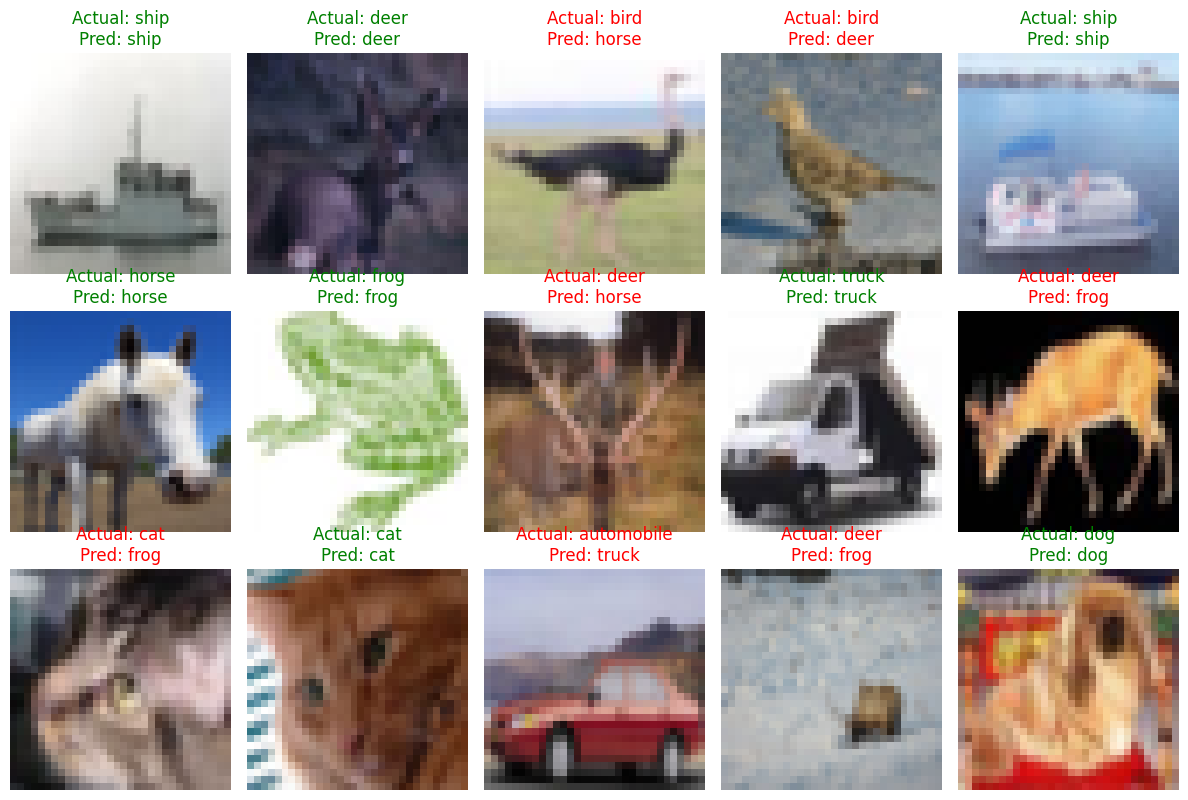

In [ ]:
plot_sample_classification_predictions(model_class, x_test, y_test_class)

### **Regression**

In [10]:
def create_alexnet_reg(input_shape):
    model = Sequential()

    model.add(Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    # flattening the output from convolution layers
    model.add(Flatten())

    # fully connected layer 1
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # fully connected layer 2
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # regression layer
    model.add(Dense(1, activation='linear'))

    return model

In [11]:
with tf.device('/GPU:0'):
    model_reg = create_alexnet_reg(input_shape)
    model_reg.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
    history_reg = model_reg.fit(x_train, y_train_reg, epochs=10, batch_size=64, validation_data=(x_test, y_test_reg))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 8.7089 - mae: 2.5179 - val_loss: 7.5829 - val_mae: 2.2666
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 7.4323 - mae: 2.2887 - val_loss: 7.0948 - val_mae: 2.2547
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 7.0470 - mae: 2.2054 - val_loss: 6.9285 - val_mae: 2.1991
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 6.8313 - mae: 2.1540 - val_loss: 6.9953 - val_mae: 2.0925
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 6.5932 - mae: 2.0942 - val_loss: 6.9678 - val_mae: 2.1626
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 6.3775 - mae: 2.0466 - val_loss: 6.4792 - val_mae: 2.0551
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.2224 - mae: 2.0094 - val_loss: 6.3654 - val_mae: 2.0677
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 6.0176 - mae: 1.9624 - val_loss: 6.2634 - val_mae: 2.0050
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10m

In [12]:
test_loss_reg, test_mae_reg = model_reg.evaluate(x_test, y_test_reg)
print(f"Test MAE for Regression Task: {test_mae_reg:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.9064 - mae: 1.8904
Test MAE for Regression Task: 1.87


#**Task 01**

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


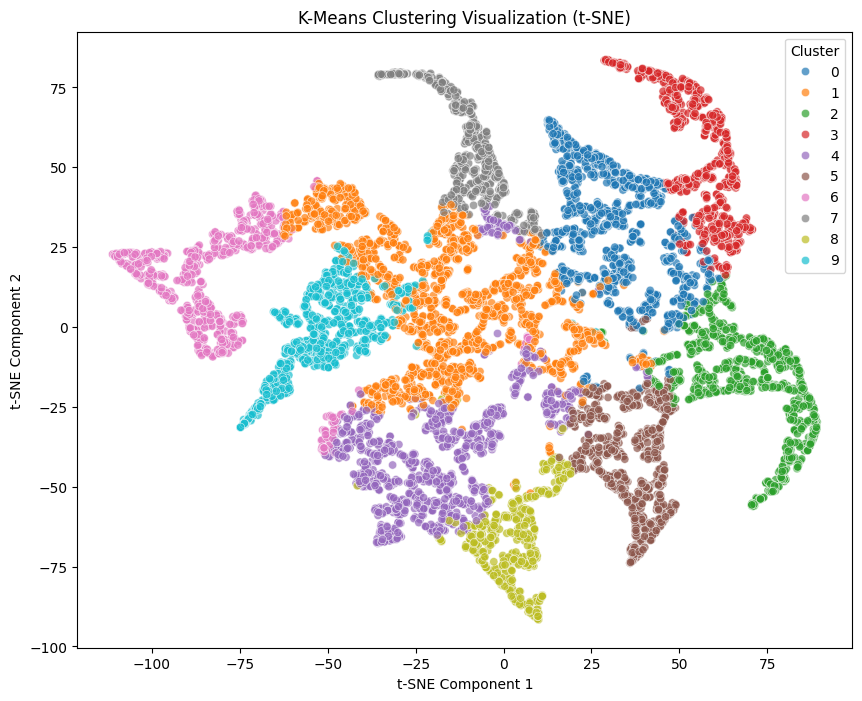

In [13]:
# *************************************************
# TASK 1 - CONVERT ALEXNET INTO A FEATURE EXTRACTOR
# *************************************************

# Remove the final classification layer from AlexNet. Pass images through
# the modified model and extract feature embeddings. Use K-Means clustering
# on these embeddings to group similar images.

# WRITE YOUR CODE HERE
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

model_reg.pop()
model_reg.pop()
features_test = model_class.predict(x_test, batch_size=32)

features_test = features_test.reshape(features_test.shape[0], -1)

# Apply K-Means Clustering
num_clusters = 10  # CIFAR-10 has 10 categories

# Fit K-Means model on extracted features
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_test)

# Visualizing the Clusters using t-SNE
def visualize_clusters(features, labels, num_classes=10):
    """Reduces feature dimensions using t-SNE and plots clusters."""
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette="tab10", alpha=0.7)
    plt.title("K-Means Clustering Visualization (t-SNE)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Cluster")
    plt.show()

# Plot the clusters
visualize_clusters(features_test, cluster_labels)
# *************************************************
# *************************************************

#**Task 02**

In [ ]:
# **************************************************
# TASK 2 - IMPROVING ALEXNET PERFORMANCE ON CIFAR-10
# **************************************************

# Experiment with different hyperparameters, optimizers, and loss functions to
# improve the classification accuracy of AlexNet on CIFAR-10 dataset.

# WRITE YOUR CODE HERE


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, LogCosh, CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt

# Define hyperparameters
learning_rates = [0.001, 0.0001, 0.5, 0.01]
batch_sizes = [32, 64, 128]
epochs_list = [10, 20 ]
optimizers = [Adam, SGD, RMSprop, Adagrad]
dropout_rates = [0.3, 0.4, 0.5, 0.6]
loss_functions = [MeanAbsoluteError(), LogCosh(), CategoricalCrossentropy()]
# Define function for AlexNet
def create_alexnet_class(input_shape, num_classes=10, dropout_rate=0.5):
    model = Sequential()

    model.add(Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    # Flattening the output from convolution layers
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Fully connected layer 2
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Classification layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Loop through different hyperparameters
input_shape = (32, 32, 3)
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs_list:
            for optimizer in optimizers:
                for dropout_rate in dropout_rates:
                    for loss in loss_functions:
                        print(f"Training with Optimizer: {optimizer.__name__}, Learning Rate: {lr}, "
                              f"Batch Size: {batch_size}, Dropout: {dropout_rate}, Loss: {loss.name}")

                        # Initialize optimizer with learning rate
                        opt = optimizer(learning_rate=lr)

                        # Create model
                        model_class = create_alexnet_class(input_shape, num_classes=10, dropout_rate=dropout_rate)

                        # Compile model
                        model_class.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

                        # Train model
                        with tf.device('/GPU:0'):
                            history_class = model_class.fit(
                                x_train, y_train_class, epochs=epoch, batch_size=batch_size,
                                validation_data=(x_test, y_test_class), verbose=1
                            )

                        # Evaluate model
                        test_loss_class, test_acc_class = model_class.evaluate(x_test, y_test_class)
                        print(f"Test Accuracy for Classification Task: {test_acc_class * 100:.2f}%")


# **************************************************
# **************************************************

Training with Optimizer: Adam, Learning Rate: 0.001, Batch Size: 32, Dropout: 0.3, Loss: mean_absolute_error


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.1004 - loss: 0.1798 - val_accuracy: 0.1000 - val_loss: 0.1800
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.0987 - loss: 0.1803 - val_accuracy: 0.1000 - val_loss: 0.1800
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.0991 - loss: 0.1802 - val_accuracy: 0.1000 - val_loss: 0.1800
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.1027 - loss: 0.1795 - val_accuracy: 0.1000 - val_loss: 0.1800
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.1006 - loss: 0.1799 - val_accuracy: 0.1000 - val_loss: 0.1800
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.1002 - loss: 0.1800 - val_accuracy: 0.1000 - val_loss: 0.1800
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.0997 - loss: 0.1801 - val_accuracy: 0.1000 - val_loss: 0.1800
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1000 - loss: 

## **VGGNet**

The company Visual Geometry Group created VGGNet (by Oxford University). While GoogLeNet won the classification assignment at ILSVR2014, this architecture came first. Understanding VGGNet is important since many contemporary image classification models are constructed on top of it.

It has a typical deep CNN design with numerous layers, with VGG-16 or VGG-19 having 16 or 19 convolutional layers, respectively. VGG-19, the deeper variant of the VGG models, has garnered considerable attention due to its simplicity and effectiveness. The VGG models were introduced by Karen Simonyan and Andrew Zisserman in their 2014 paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition." The primary objective was to investigate the effect of increasing the depth of CNNs on large-scale image recognition tasks. VGG-16 and VGG-19 were among the most notable models presented in the paper. Their design was characterized by using small 3x3 convolution filters consistently across all layers, which simplified the network structure and improved performance.

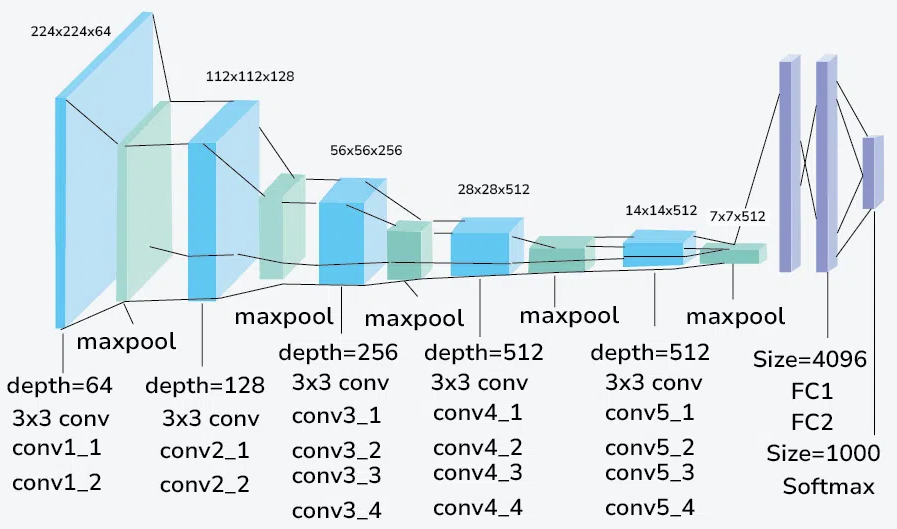

Key components of the VGG-19 architecture are:

*   3x3 filters with a stride of 1 and padding of 1 to preserve spatial resolution.
*   ReLU (Rectified Linear Unit) applied after each convolutional layer to introduce non-linearity.
*   Max pooling with a 2x2 filter and a stride of 2 to reduce the spatial dimensions.
*   Three fully connected layers at the end of the network for classification.
*   Final layer for outputting class probabilities.

### **Classification**

In [15]:
def create_vggnet_class(input_shape, num_classes=10):
    model = Sequential()

    # block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # flattening
    model.add(Flatten())

    # fully connected layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # classification layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [16]:
# defining the input shape for CIFAR-10 (32x32 RGB images)
input_shape = (32, 32, 3)

In [17]:
with tf.device('/GPU:0'):
    model_class = create_vggnet_class(input_shape=(32, 32, 3), num_classes=10)
    model_class.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history_class = model_class.fit(x_train, y_train_class, epochs=10, batch_size=64, validation_data=(x_test, y_test_class))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 42ms/step - accuracy: 0.0957 - loss: 2.3039 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - accuracy: 0.1004 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.0991 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.0992 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.1003 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.0994 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.0966 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.1004 - loss: 2.3027 - 

In [18]:
test_loss_class, test_acc_class = model_class.evaluate(x_test, y_test_class)
print(f"Test Accuracy for Classification Task: {test_acc_class * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1036 - loss: 2.3026
Test Accuracy for Classification Task: 10.00%


### **Regression**

In [19]:
def create_vggnet_reg(input_shape):
    model = Sequential()

    # block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # flattening
    model.add(Flatten())

    # fully connected layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # regression layer
    model.add(Dense(1, activation='linear'))

    return model

In [20]:
with tf.device('/GPU:0'):
    model_reg = create_vggnet_reg(input_shape)
    model_reg.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
    history_reg = model_reg.fit(x_train, y_train_reg, epochs=10, batch_size=64, validation_data=(x_test, y_test_reg))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 33.1990 - mae: 3.5701 - val_loss: 8.2823 - val_mae: 2.5000
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 8.3888 - mae: 2.5099 - val_loss: 8.2588 - val_mae: 2.5000
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 8.3317 - mae: 2.5007 - val_loss: 8.2500 - val_mae: 2.5000
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 8.3560 - mae: 2.5066 - val_loss: 8.2647 - val_mae: 2.5000
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 8.2835 - mae: 2.4945 - val_loss: 8.2522 - val_mae: 2.5000
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 8.3215 - mae: 2.5028 - val_loss: 8.2504 - val_mae: 2.5000
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 8.3306 - mae: 2.5065 - val_loss: 8.2505 - val_mae: 2.5000
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 8.2791 - mae: 2.4950 - val_loss: 8.2530 - val_mae: 2.5000
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━

In [21]:
test_loss_reg, test_mae_reg = model_reg.evaluate(x_test, y_test_reg)
print(f"Test MAE for Regression Task: {test_mae_reg:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.3045 - mae: 2.5066
Test MAE for Regression Task: 2.50


#**Task 03**

In [9]:
# ****************************************
# TASK 3 - FINE-TUNING A PRE-TRAINED MODEL
# ****************************************

# Load a pre-trained deep learning model. Replace the final classification
# layer with a new dense layer. Freeze the initial layers and fine-tune only
# the top layers. Train the modified network and evaluate its performance.

# WRITE YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, LogCosh, CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt


# Load the pre-trained MobileNetV2 model without the top classification layer
# Use input_shape=(32, 32, 3) for CIFAR-10 images
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

# Add a new classification head on top of the base model
x = base_model.output  # Output of the base model (last convolutional layer)

# Add a Global Average Pooling layer to reduce spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

# Add a fully connected (Dense) layer with 256 units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
# CIFAR-10 has 10 output classes
predictions = layers.Dense(10, activation='softmax')(x)

# Create the final model
model = models.Model(inputs=base_model.input, outputs=predictions)

# Print the summary of the new model
model.summary()

# Compile the model
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train_class, epochs=10, batch_size=64, validation_data=(x_test, y_test_class))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test_class)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

<ipython-input-9-5c9772f977ff>:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_3 (Cast)             │ (None, 32, 32, 3)      │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ cast_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 283s 352ms/step - accuracy: 0.2757 - loss: 2.0158 - val_accuracy: 0.3232 - val_loss: 1.8762
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 355s 395ms/step - accuracy: 0.3312 - loss: 1.8462 - val_accuracy: 0.3356 - val_loss: 1.8365
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 308s 394ms/step - accuracy: 0.3414 - loss: 1.8095 - val_accuracy: 0.3387 - val_loss: 1.8218
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 308s 393ms/step - accuracy: 0.3528 - loss: 1.7834 - val_accuracy: 0.3502 - val_loss: 1.8039
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 309s 395ms/step - accuracy: 0.3572 - loss: 1.7659 - val_accuracy: 0.3540 - val_loss: 1.8036
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 311s 398ms/step - accuracy: 0.3734 - loss: 1.7427 - val_accuracy: 0.3556 - val_loss: 1.7927
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 318s 393ms/step - accuracy: 0.3731 - loss: 1.7303 - val_accuracy: 0.3594 - val_loss: 1.7899
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 321s 392ms/step - accuracy: 0.3817 -

# **Task 1: Convert AlexNet into a Feature Extractor**  

The goal of this task is to modify the AlexNet model so that instead of classifying images, it **extracts meaningful features** from them. These extracted features will then be used for **unsupervised clustering** using **K-Means**.  

### **Steps Involved:**  
1. **Modify AlexNet:**  
   - Remove the final classification layer from the AlexNet model.  
   - This turns it into a **feature extractor**, meaning it outputs high-level features instead of class labels.  

2. **Extract Features:**  
   - Pass test images through the modified model to get feature embeddings.  
   - Flatten the extracted features so they can be used for clustering.  

3. **Apply K-Means Clustering:**  
   - Use **K-Means** to group images into **10 clusters** (since CIFAR-10 has 10 categories).  

4. **Visualize the Clusters:**  
   - Reduce the high-dimensional features to **2D** using **t-SNE**.  
   - Plot the clustered points to analyze how well the images are grouped.  

### **Observations:**
This approach helped me in understanding how well the network distinguishes between different objects without directly using labels.

# **Task 2: Checking different hyperparameters, optimizers and loss functions**  

The goal was to check different hyperparameters, loss functions and optimizers.

### **My Strategy:**
I wrote all the possible suitable combinations I could think of, put them in a loop and ran the cell. The total combinations for training was 1152 runs. Obviously, I could not run all the runs. So, I ran the cell for 5-6 hours and attained results on as many combinations as I could.

###**Results:**
| Optimizer | Learning Rate | Batch Size | Dropout | Loss Function               | Test Accuracy |
|-----------|---------------|------------|---------|-----------------------------|---------------|
| Adam      | 0.001         | 32         | 0.3     | mean_absolute_error         | 10.00%        |
| Adam      | 0.001         | 32         | 0.3     | log_cosh                    | 49.26%        |
| Adam      | 0.001         | 32         | 0.3     | categorical_crossentropy    | 10.00%        |
| Adam      | 0.001         | 32         | 0.4     | mean_absolute_error         | 10.00%        |
| Adam      | 0.001         | 32         | 0.4     | log_cosh                    | 10.00%        |
| Adam      | 0.001         | 32         | 0.4     | categorical_crossentropy    | 10.00%        |
| Adam      | 0.001         | 32         | 0.5     | mean_absolute_error         | 10.00%        |
| Adam      | 0.001         | 32         | 0.5     | log_cosh                    | 10.00%        |
| Adam      | 0.001         | 32         | 0.5     | categorical_crossentropy    | 10.00%        |
| Adam      | 0.001         | 32         | 0.6     | mean_absolute_error         | 10.00%        |
| Adam      | 0.001         | 32         | 0.6     | log_cosh                    | 10.00%        |
| Adam      | 0.001         | 32         | 0.6     | categorical_crossentropy    | 10.00%        |
| SGD       | 0.001         | 32         | 0.3     | mean_absolute_error         | 10.06%        |
| SGD       | 0.001         | 32         | 0.3     | log_cosh                    | 9.78%         |
| SGD       | 0.001         | 32         | 0.3     | categorical_crossentropy    | 21.80%        |
| SGD       | 0.001         | 32         | 0.4     | mean_absolute_error         | 11.20%        |
| SGD       | 0.001         | 32         | 0.4     | log_cosh                    | 10.00%        |
| SGD       | 0.001         | 32         | 0.4     | categorical_crossentropy    | 17.59%        |
| SGD       | 0.001         | 32         | 0.5     | mean_absolute_error         | 11.28%        |
| SGD       | 0.001         | 32         | 0.5     | log_cosh                    | 11.29%        |
| SGD       | 0.001         | 32         | 0.5     | categorical_crossentropy    | 16.59%        |
| SGD       | 0.001         | 32         | 0.6     | mean_absolute_error         | 11.54%        |
| SGD       | 0.001         | 32         | 0.6     | log_cosh                    | 8.35%         |
| SGD       | 0.001         | 32         | 0.6     | categorical_crossentropy    | 18.86%        |
| RMSprop   | 0.001         | 32         | 0.3     | mean_absolute_error         | 18.53%        |
| RMSprop   | 0.001         | 32         | 0.3     | log_cosh                    | 50.93%        |
| RMSprop   | 0.001         | 32         | 0.3     | categorical_crossentropy    | 54.29%        |
| RMSprop   | 0.001         | 32         | 0.4     | mean_absolute_error         | 11.91%        |
| RMSprop   | 0.001         | 32         | 0.4     | log_cosh                    | 53.72%        |
| RMSprop   | 0.001         | 32         | 0.4     | categorical_crossentropy    | 56.15%        |
| RMSprop   | 0.001         | 32         | 0.5     | mean_absolute_error         | 15.21%        |
| RMSprop   | 0.001         | 32         | 0.5     | log_cosh                    | 51.53%        |
| RMSprop   | 0.001         | 32         | 0.5     | categorical_crossentropy    | 50.69%        |
| RMSprop   | 0.001         | 32         | 0.6     | mean_absolute_error         | 15.01%        |
| RMSprop   | 0.001         | 32         | 0.6     | log_cosh                    | 44.13%        |
| RMSprop   | 0.001         | 32         | 0.6     | categorical_crossentropy    | 44.09%        |
| Adagrad   | 0.001         | 32         | 0.3     | mean_absolute_error         | 11.01%        |
| Adagrad   | 0.001         | 32         | 0.3     | log_cosh                    | 17.67%        |
| Adagrad   | 0.001         | 32         | 0.3     | categorical_crossentropy    | 18.47%        |
| Adagrad   | 0.001         | 32         | 0.4     | mean_absolute_error         | 13.85%        |
| Adagrad   | 0.001         | 32         | 0.4     | log_cosh                    | 11.99%        |
| Adagrad   | 0.001         | 32         | 0.4     | categorical_crossentropy    | 17.58%        |
| Adagrad   | 0.001         | 32         | 0.5     | mean_absolute_error         | 14.53%        |
| Adagrad   | 0.001         | 32         | 0.5     | log_cosh                    | 12.73%        |
| Adagrad   | 0.001         | 32         | 0.5     | categorical_crossentropy    | 18.17%        |
| Adagrad   | 0.001         | 32         | 0.6     | mean_absolute_error         | 11.97%        |
| Adagrad   | 0.001         | 32         | 0.6     | log_cosh                    | 10.00%        |
| Adagrad   | 0.001         | 32         | 0.6     | categorical_crossentropy    | 18.49%        |
| Adam      | 0.001         | 32         | 0.3     | mean_absolute_error         | 10.00%        |
| Adam      | 0.001         | 32         | 0.3     | log_cosh                    | 10.00%        |
| Adam      | 0.001         | 32         | 0.3     | categorical_crossentropy    | 51.72%        |
| Adam      | 0.001         | 32         | 0.4     | mean_absolute_error         | 10.00%        |
| Adam      | 0.001         | 32         | 0.4     | log_cosh                    | 10.00%        |
| Adam      | 0.001         | 32         | 0.4     | categorical_crossentropy    | 10.00%        |
| Adam      | 0.001         | 32         | 0.5     | mean_absolute_error         | 10.00%        |
| Adam      | 0.001         | 32         | 0.5     | log_cosh                    | 10.00%        |
| Adam      | 0.001         | 32         | 0.5     | categorical_crossentropy    | 10.00%        |

This table summarizes the test accuracy for each combination of optimizer, learning rate, batch size, dropout, and loss function.



### **Hyperparameters Tested**:
   - **Optimizers**: Adam, SGD, RMSprop, Adagrad.
   - **Learning Rate**: Fixed at 0.001 for all experiments.
   - **Batch Size**: Fixed at 32 for all experiments.
   - **Dropout Rates**: Tested at 0.3, 0.4, 0.5, and 0.6.
   - **Loss Functions**: `mean_absolute_error`, `log_cosh`, and `categorical_crossentropy`.

### **Training Process**:
   - Each configuration was trained for 10 epochs (or 20 epochs in some cases).
   - The training and validation accuracy/loss were monitored for each epoch.
   - The final test accuracy was reported after evaluating the model on a test dataset.

### **Evaluation Metric**:
   - The primary metric used to evaluate the model's performance was **test accuracy**, which measures the percentage of correctly classified samples in the test set.

---

### **Observations and Results**

1. **Performance Across Optimizers**:
   - **Adam**: Performed poorly with `mean_absolute_error` and `log_cosh` (test accuracy ~10%), but achieved **49.26%** accuracy with `log_cosh` and **51.72%** with `categorical_crossentropy` in some configurations.
   - **SGD**: Generally performed better than Adam, with test accuracies ranging from **8.35%** to **21.80%**. The best performance was with `categorical_crossentropy`.
   - **RMSprop**: Achieved the highest test accuracies, with **56.15%** using `categorical_crossentropy` and **50.93%** using `log_cosh`.
   - **Adagrad**: Performed moderately, with test accuracies ranging from **10.00%** to **18.49%**.

2. **Effect of Dropout**:
   - Dropout rates of 0.3 and 0.4 generally yielded better results compared to higher dropout rates (0.5 and 0.6).
   - Higher dropout rates (e.g., 0.6) often led to lower test accuracies, suggesting that too much dropout can hinder the model's ability to learn.

3. **Effect of Loss Functions**:
   - `categorical_crossentropy` consistently performed better than `mean_absolute_error` and `log_cosh` across most optimizers.
   - `mean_absolute_error` and `log_cosh` struggled to achieve high test accuracies, often resulting in **~10%** accuracy, which is close to random guessing for a 10-class classification problem.

4. **Best Configuration**:
   - The best-performing configuration was **RMSprop** with a **learning rate of 0.001**, **batch size of 32**, **dropout of 0.4**, and **categorical_crossentropy** loss, achieving a test accuracy of **56.15%**.

---


### **Conclusion**

This task demonstrated the importance of selecting appropriate hyperparameters and loss functions for neural network training. While RMSprop with `categorical_crossentropy` yielded the best results, other configurations struggled to achieve high accuracy.


# **Task 3 - Fine-Tuning a Pre-Trained Model**  

In this task, I fine-tuned a **pre-trained deep learning model** (MobileNetV2) on the **CIFAR-10** dataset. Fine-tuning leverages the knowledge learned by a model trained on a large dataset (ImageNet) and adapts it to a new, smaller dataset.

I used MobilenetV2 because my colab free limit was expired and mobile net is one of the most light weighted architectures that could go smoothly with my CPU.

#### **Steps Involved:**  
1. **Load a Pre-Trained Model:**  
   - I used **MobileNetV2**, a lightweight deep learning model trained on ImageNet.  
   - The **top classification layer is removed** (`include_top=False`) so I could add more layers.  
   - The input size is set to **(32, 32, 3)** to match CIFAR-10 images.  

2. **Modify the Model:**  
   - I froze the initial layers (`base_model.trainable = False`) so they retain the pre-trained weights.  
   - A **Global Average Pooling (GAP) layer** is added to reduce spatial dimensions.  
   - A **fully connected dense layer** (256 neurons, ReLU activation) is added.  
   - A final **softmax layer** (10 classes for CIFAR-10) is added for classification.  

3. **Compile and Train:**  
   - The model is compiled with **RMSProp optimizer** and **categorical cross-entropy loss**.  
   - The training is performed on **CIFAR-10** with `epochs=10` and `batch_size=64`.  

4. **Evaluation:**  
   - The fine-tuned model is evaluated on the test set to measure performance.  
   - The final **test accuracy that is 36.6%** is printed. It is quite better than the accuracy that VGGNet was giving(10%).

Fine-tuning helps improve performance by **transferring learned features** from a large dataset (ImageNet) to a smaller dataset (CIFAR-10), **reducing training time and improving accuracy.**